In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import math
from sklearn.preprocessing import StandardScaler 

In [2]:
# input the stock ticker we wana study
stock_ticker = "TSLA"
current_date = '2025-03-28'
maturity_date = '2025-04-17'
option_type = 'call' 

In [3]:
# read option chain file
df = pd.read_excel('Combined_' + stock_ticker + '_options_15-Apr-25.xlsx')

In [ ]:
# Function to get option chain in the dataframe
# Select option chain with specific current date and maturity date
def get_option_chain(df_input, symbol_input, direction, current_date_input, maturity_date_input=None):
    # Ignore maturity date when the user doesn't put in a maturity date
    condition = (df_input["Symbol"] == symbol_input) & (df_input['Direction'] == direction) & (df_input['Current Date'] == current_date_input)
    # Filter with maturity date when the user put in a maturity date
    if not maturity_date_input is None:
        condition = condition & (df_input['Expiration Date'] == maturity_date_input)
    df_res = df_input[condition]
    return df_res

# Function to perform linear regression with list of columns as input, using sm.OLS
def linear_regression(df_input, y_col, x_cols):
    df = df_input
    X = df[x_cols]
    y = df[y_col]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit()
    return model

# Define a function to plot the IVM across moneyness with maturity in the legend
def plot_ivm_across_moneyness(df_input, symbol_input, direction_input, current_date_input):

    # Filter the data for the specified stock, direction, and date
    df_target = get_option_chain(df_input, symbol_input, direction_input, current_date_input)
    
    # Group by maturity (maturity_years)
    grouped = df_target.groupby('maturity_years')
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    for maturity, group in grouped:
        plt.scatter(group['moneyness'], group['IVM'], label=f'Maturity: {maturity:.2f} years')
    
    # Add labels, title, legend, and grid
    plt.xlabel('Moneyness')
    plt.ylabel('IVM')
    plt.title(f'IVM across Moneyness for {symbol_input} {direction_input} options on {current_date_input}')
    plt.legend(title='Maturity (years)', loc='best')
    plt.grid()
    plt.show()

# Function to plot 3D graph of IVM across moneyness and maturity_years
def plot_ivm_across_moneyness_and_days(df, symbol_input, direction, current_date_input):

    # Get the filtered option chain
    df_target = get_option_chain(df, symbol_input, direction, current_date_input)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_target['moneyness'], 
               df_target['maturity_years'], 
               df_target['IVM'], 
               color='blue')
    
    # Set labels and title
    ax.set_xlabel('Moneyness')
    ax.set_ylabel('Time to Maturity (in years)')
    ax.set_zlabel('IVM')
    ax.set_title(f'IVM across Moneyness and Time to Maturity for {symbol_input} {direction} options on {current_date_input}')
    
    # Show the plot
    plt.show()

# Function to input current stock price, strike, maturity date and direction, then output moneyess, maturity_years,'moneyness_2', 'maturity_2', 'moneyness_maturity' in list
def get_warrant_moneyness_expiration(current_stock_price, strike, maturity_date_input, current_date_input):
    # Convert dates to datetime format
    current_date = pd.to_datetime(current_date_input)
    maturity_date = pd.to_datetime(maturity_date_input)
    
    # Calculate moneyness and maturity_years
    moneyness = current_stock_price / strike
    time_to_expiration_days = (maturity_date - current_date).days
    time_to_expiration_years = time_to_expiration_days / 365
    
    # Calculate squares and products
    moneyness_2 = moneyness ** 2
    maturity_2 = time_to_expiration_years ** 2
    moneyness_maturity = moneyness * time_to_expiration_years
    
    return [moneyness, time_to_expiration_years, moneyness_2, maturity_2, moneyness_maturity]

# Define a function of bidirectional stepwise regression
def stepwise_regression(df, target_col, predictor_cols, p_entry=0.05, p_remove=0.1):
    """
    Perform bidirectional stepwise regression using statsmodels.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data
    - target_col (str): Name of the dependent variable column
    - predictor_cols (list): List of independent variable column names
    - p_entry (float): P-value threshold to add a predictor (default: 0.05)
    - p_remove (float): P-value threshold to remove a predictor (default: 0.1)
    
    Returns:
    - model: Fitted statsmodels OLS model with selected predictors
    - selected_predictors: List of selected predictor columns
    """
    # Ensure no missing values in target or predictors
    data = df[[target_col] + predictor_cols].dropna()
    
    # Separate dependent and independent variables
    y = data[target_col]
    X = data[predictor_cols]
    
    # Initialize selected predictors
    selected_predictors = []
    remaining_predictors = predictor_cols.copy()
    
    # Add constant for intercept
    X_selected = sm.add_constant(y)  # Start with only constant
    
    # Initialize model
    model = sm.OLS(y, X_selected).fit()
    
    # Track best model
    best_aic = model.aic
    
    # Bidirectional stepwise loop
    while remaining_predictors:
        # Forward selection: Try adding each remaining predictor
        p_values = {}
        for predictor in remaining_predictors:
            # Add predictor to current model
            X_temp = X_selected.copy()
            X_temp[predictor] = X[predictor]
            temp_model = sm.OLS(y, X_temp).fit()
            p_values[predictor] = temp_model.pvalues[predictor]
        
        # Find predictor with minimum p-value
        min_p = min(p_values.values(), default=float('inf'))
        best_predictor = min(p_values, key=p_values.get, default=None)
        
        # Add predictor if p-value < p_entry
        if min_p < p_entry:
            selected_predictors.append(best_predictor)
            remaining_predictors.remove(best_predictor)
            X_selected[best_predictor] = X[best_predictor]
            model = sm.OLS(y, X_selected).fit()
            new_aic = model.aic
            
            # Backward elimination: Check if any predictors should be removed
            while True:
                p_values = model.pvalues.drop('const', errors='ignore')
                max_p = p_values.max() if not p_values.empty else 0
                worst_predictor = p_values.idxmax() if not p_values.empty else None
                
                if worst_predictor and max_p > p_remove:
                    selected_predictors.remove(worst_predictor)
                    remaining_predictors.append(worst_predictor)
                    X_selected = X_selected.drop(columns=worst_predictor)
                    model = sm.OLS(y, X_selected).fit()
                else:
                    break
            
            # Update best model if AIC improves
            if model.aic < best_aic:
                best_aic = model.aic
            else:
                # Stop if no improvement
                break
        else:
            # Stop if no predictor meets p_entry
            break
    
    return model, selected_predictors

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11199 entries, 0 to 11198
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ticker                    11199 non-null  object 
 1   Symbol                    11199 non-null  object 
 2   Expiration Date           11199 non-null  object 
 3   Strike                    11199 non-null  float64
 4   Bid                       11199 non-null  float64
 5   Ask                       11199 non-null  float64
 6   Last                      11199 non-null  float64
 7   IVM                       11199 non-null  float64
 8   Direction                 11199 non-null  object 
 9   Current Date              11199 non-null  object 
 10  Current Date Stock Price  11199 non-null  float64
dtypes: float64(6), object(5)
memory usage: 962.5+ KB


In [6]:
#show unique values in "Expiration Date" in ascending order
date_count = df["Expiration Date"].value_counts().reset_index()
date_count["Expiration Date"] = pd.to_datetime(date_count["Expiration Date"])
date_count.set_index("Expiration Date", inplace=True)
date_count = date_count.sort_index()
date_count

,count
Expiration Date,
2025-01-17,880
2025-02-21,2720
2025-03-21,3359
2025-04-17,2880
2025-04-25,160
2025-05-16,1200


In [7]:
# Remove rows where "IVM" is 0
df = df[df['IVM'] != 0]
df.head()

,Ticker,Symbol,Expiration Date,Strike,Bid,Ask,Last,IVM,Direction,Current Date,Current Date Stock Price
1,TSLA 4/17/25 P207.5,TSLA,17-Apr-2025,207.5,0.120000,0.140000,0.12,105.147621,put,15-Apr-2025,254.110001
2,TSLA 4/17/25 P262.5,TSLA,17-Apr-2025,262.5,11.400000,11.600000,10.70,62.645725,put,15-Apr-2025,254.110001
3,TSLA 4/17/25 P265,TSLA,17-Apr-2025,265.0,13.350000,13.600000,12.48,63.222397,put,15-Apr-2025,254.110001
4,TSLA 4/17/25 P267.5,TSLA,17-Apr-2025,267.5,15.450000,15.700000,14.60,64.077888,put,15-Apr-2025,254.110001
5,TSLA 4/17/25 P270,TSLA,17-Apr-2025,270.0,17.550003,17.899994,16.75,64.198608,put,15-Apr-2025,254.110001


In [8]:
# Add columns for regression

# Ensure 'Expiration Date' and 'Current Date' are in datetime format
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
df['Current Date'] = pd.to_datetime(df['Current Date'])

# Add moneyness, time to maturity in days and time to maturity in years
df['moneyness'] = df['Current Date Stock Price'] / df['Strike']
df['maturity_days'] = (df['Expiration Date'] - df['Current Date']).dt.days
df['maturity_years'] = df['maturity_days'] / 365

# Transform moneyness, time_to_maturity_days, maturity_years and IVM to between 0 and 1
cols_to_standardize = ['moneyness', 'maturity_days', "maturity_years", "IVM"]
for col in cols_to_standardize:
       df[col] =  (df[col] - np.min(df[col].values)) / (np.max(df[col].values) - np.min(df[col].values))


col_order = ['Ticker', 'Symbol', 'Direction', 'Current Date', 'Expiration Date', 'maturity_days', 'maturity_years', 'Current Date Stock Price', 'Strike', 'Bid', 'Ask', 'Last',
       'IVM', 'moneyness']
df = df.loc[:, col_order]

df.describe()

,Current Date,Expiration Date,maturity_days,maturity_years,Current Date Stock Price,Strike,Bid,Ask,Last,IVM,moneyness
count,10704,10704,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000
mean,2025-02-22 21:17:21.255605248,2025-03-23 01:33:37.937219840,0.402542,0.402542,322.979204,323.440069,30.143513,30.863887,29.052094,0.016370,0.328525
min,2025-01-02 00:00:00,2025-01-17 00:00:00,0.000000,0.000000,221.860001,125.000000,0.000000,0.010000,0.000000,0.000000,0.000000
25%,2025-01-28 00:00:00,2025-02-21 00:00:00,0.185714,0.185714,263.450012,265.000000,5.950000,6.100000,5.340000,0.008930,0.231087
50%,2025-02-24 00:00:00,2025-03-21 00:00:00,0.414286,0.414286,328.500000,320.000000,19.850006,20.149994,18.714998,0.010699,0.311173
75%,2025-03-21 00:00:00,2025-04-17 00:00:00,0.614286,0.614286,394.739990,375.000000,45.199997,46.362503,43.709999,0.013085,0.406874
max,2025-04-15 00:00:00,2025-05-16 00:00:00,1.000000,1.000000,428.220001,525.000000,192.949997,194.199997,188.250000,1.000000,1.000000
std,NaN,NaN,0.243292,0.243292,67.356963,73.908591,30.793049,31.526860,30.267034,0.046569,0.143760


In [30]:
# Add columns for moneyness squared, moneyness cubed and moneyness quadrupled
df['moneyness_2'], df["moneyness_3"] = df['moneyness'] ** 2, df["moneyness"] ** 3

# Add columns for maturity squared, maturity cubed and maturity quadrupled
df['maturity_2'], df['maturity_3'] = df['maturity_years'] ** 2, df['maturity_years'] ** 3

# Add interaction term of moneyness and maturity
df['moneyness_maturity'] = df['moneyness'] * df['maturity_years']

# Add inverse of moneyness
df['moneyness_inv1'] = 1 / df['moneyness']

# Add inverse of maturity
df['maturity_inv1'] = 1 / df['maturity_years']

# col_order = ['Ticker', 'Symbol', 'Current Date', 'Expiration Date', 'time_to_maturity_days', 'maturity_years', 'Current Date Stock Price', 'Strike', 'Bid', 'Ask', 'Last',
#        'IVM', 'Direction', 'moneyness', 'moneyness_2', 'maturity_2', 'moneyness_maturity', 'log_IVM']
# df = df.loc[:, col_order]

In [ ]:
# Select the option chain for a specific stock, direction, and current date and maturity date
df_target = get_option_chain(df, stock_ticker, option_type, current_date, maturity_date)

# Define the dependent and independent variables

In [10]:
# Select the option chain for a specific stock, direction, and current date and maturity date
df_target = get_option_chain(df, stock_ticker, option_type, current_date, maturity_date)

# Define the dependent and independent variables
dependent_var = 'log_IVM'  # USE log IVM
independent_vars = ['moneyness', 'maturity_years', 'moneyness_2', 'maturity_2', 'moneyness_maturity'] # we set the regressor

# Perform linear regression
regression_summary = linear_regression(df_target, dependent_var, independent_vars).summary()

# Display the regression summary
print(regression_summary)

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     433.2
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           2.13e-26
Time:                        22:38:28   Log-Likelihood:                 123.17
No. Observations:                  40   AIC:                            -240.3
Df Residuals:                      37   BIC:                            -235.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
moneyness             -2.6403      0

In [11]:
# print(df_new[['IVM']])

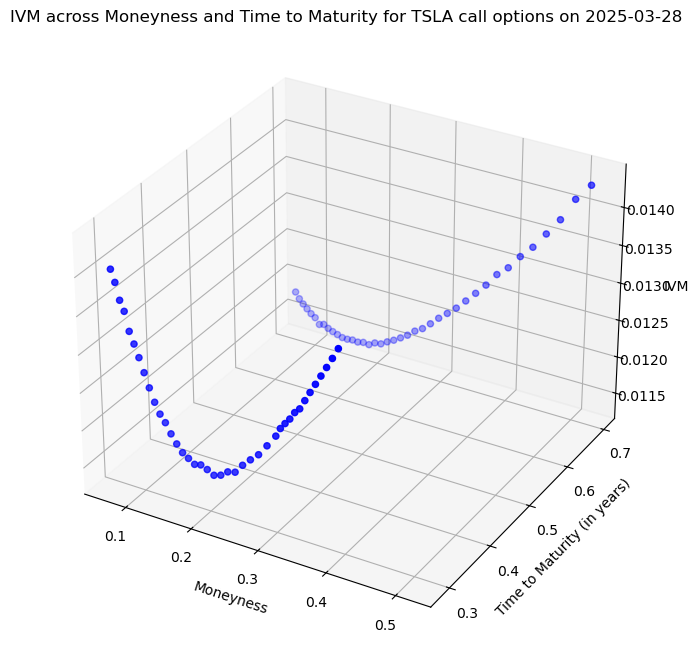

In [12]:
plot_ivm_across_moneyness_and_days(df, stock_ticker, 'call', current_date)  #show call volatility smile

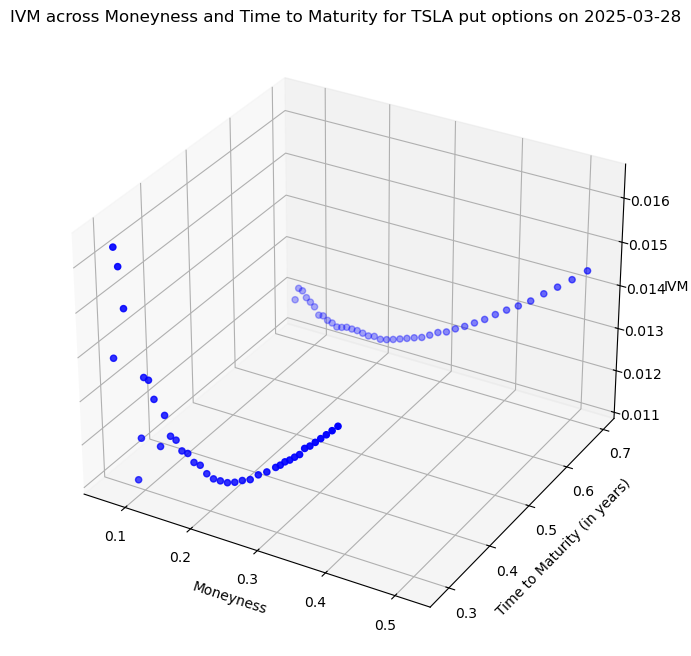

In [13]:
plot_ivm_across_moneyness_and_days(df, stock_ticker, 'put', current_date)  # show put volatility smile

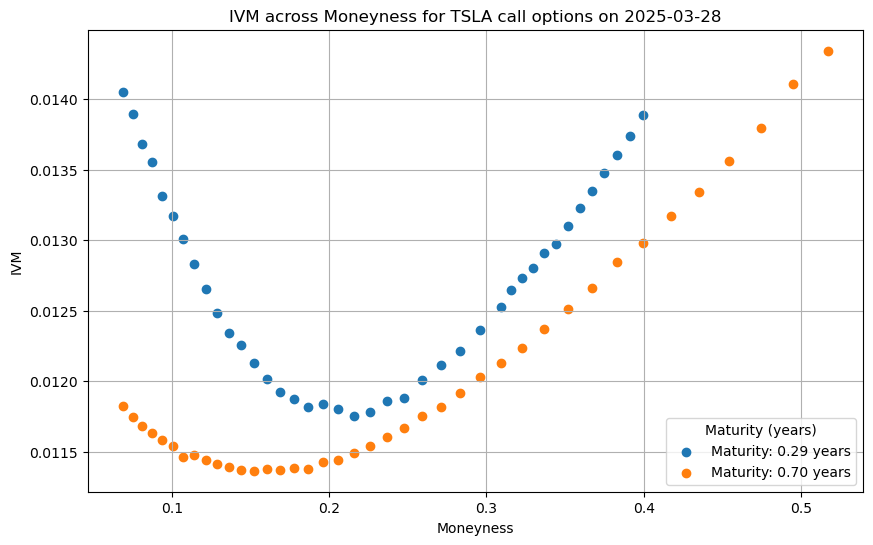

In [14]:
plot_ivm_across_moneyness(df, stock_ticker, 'call', '2025-03-28')  # show call volatility smileb

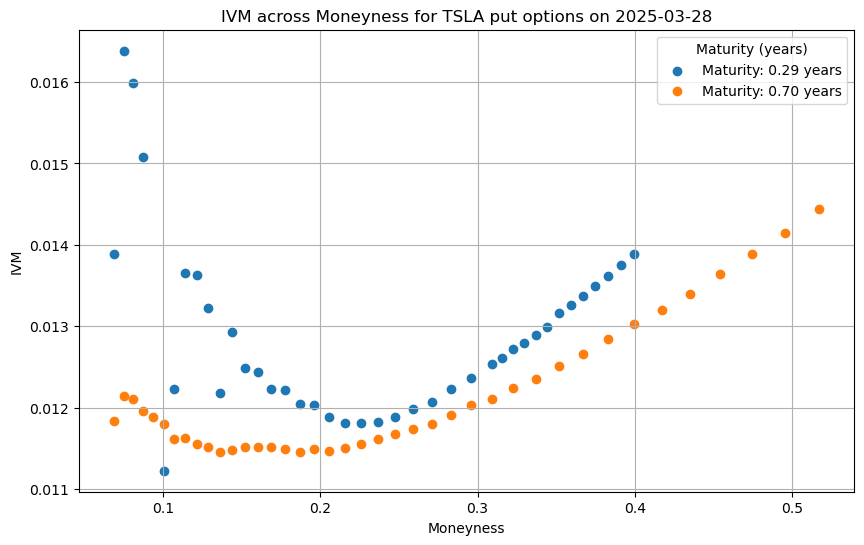

In [15]:
plot_ivm_across_moneyness(df, stock_ticker, 'put', '2025-03-28')  # show put volatility smile

We test with the following regression models, letting $K$ be moneyness, $T$ be time to maturity, $K*T$ be moneyness_maturity, $K^2$ be moneyness squared and $T^2$ be maturity squared.

- Model 1: $K, T, K*T$
- Model 2: $K, T, K^2$
- Model 3: $K, T, T^2$
- Model 4: $K, T, K^2, K*T$
- Model 5: $K, T, T^2, K*T$
- Model 6: $K, T, K^2, T^2, K*T$

In [16]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model1: K,T,K*T

independent_vars_one = ['moneyness', 'maturity_years', 'moneyness_maturity'] # model1: K,T,K*T
model = linear_regression(df_target, dependent_var, independent_vars_one)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.3867
Date:                Sat, 19 Apr 2025   Prob (F-statistic):              0.538
Time:                        22:38:29   Log-Likelihood:                 59.465
No. Observations:                  40   AIC:                            -114.9
Df Residuals:                      38   BIC:                            -111.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
moneyness              0.0491      0

In [17]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model2: K,T,K^2

independent_vars_two = ['moneyness', 'maturity_years', 'moneyness_2'] # model2: K,T,K^2
model = linear_regression(df_target, dependent_var, independent_vars_two)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     433.2
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           2.13e-26
Time:                        22:38:29   Log-Likelihood:                 123.17
No. Observations:                  40   AIC:                            -240.3
Df Residuals:                      37   BIC:                            -235.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
moneyness         -2.8558      0.101    -28.

In [18]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model3: K,T,T^2

independent_vars_three = ['moneyness', 'maturity_years', 'maturity_2'] # model3: K,T,T^2
model = linear_regression(df_target, dependent_var, independent_vars_three)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.3867
Date:                Sat, 19 Apr 2025   Prob (F-statistic):              0.538
Time:                        22:38:29   Log-Likelihood:                 59.465
No. Observations:                  40   AIC:                            -114.9
Df Residuals:                      38   BIC:                            -111.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
moneyness          0.0531      0.085      0.

In [19]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model4: K,T,K^2,K*T

independent_vars_four = ['moneyness', 'maturity_years', 'moneyness_2', 'moneyness_maturity'] # model4: K,T,K^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_four)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     433.2
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           2.13e-26
Time:                        22:38:29   Log-Likelihood:                 123.17
No. Observations:                  40   AIC:                            -240.3
Df Residuals:                      37   BIC:                            -235.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
moneyness             -2.6403      0

In [20]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model5 K,T,T^2,K*T

independent_vars_five = ['moneyness', 'maturity_years','maturity_2','moneyness_maturity'] # model5 K,T,T^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_five)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.3867
Date:                Sat, 19 Apr 2025   Prob (F-statistic):              0.538
Time:                        22:38:29   Log-Likelihood:                 59.465
No. Observations:                  40   AIC:                            -114.9
Df Residuals:                      38   BIC:                            -111.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
moneyness              0.0491      0

In [21]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model6:K,T,K^2,T^2,K*T

independent_vars_six = ['moneyness', 'maturity_years', 'moneyness_2', 'maturity_2','moneyness_maturity'] # model6:K,T,K^2,T^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_six)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     433.2
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           2.13e-26
Time:                        22:38:29   Log-Likelihood:                 123.17
No. Observations:                  40   AIC:                            -240.3
Df Residuals:                      37   BIC:                            -235.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
moneyness             -2.6403      0

In [22]:
# Function to perform linear regression with list of columns as input, using sm.OLS
#prototype regression model

independent_vars = ['moneyness', 'maturity_years', 'moneyness_2', 'maturity_2', 'moneyness_maturity']
model = linear_regression(df_target, dependent_var, independent_vars)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     433.2
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           2.13e-26
Time:                        22:38:29   Log-Likelihood:                 123.17
No. Observations:                  40   AIC:                            -240.3
Df Residuals:                      37   BIC:                            -235.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
moneyness             -2.6403      0

In [23]:
# output warrant moneyness, maturity_years, 'moneyness_2', 'maturity_2', 'moneyness_maturity' in list
#******INPUT warrant data HERE ******
current_stock_price = 277.13
strike = 350
maturity_date = '2025-05-21'
current_date = '2025-03-27'
warrant_moneyness_expiration = get_warrant_moneyness_expiration(current_stock_price, strike, maturity_date, current_date)
print(warrant_moneyness_expiration)

[0.7918, 0.1506849315068493, 0.6269472399999999, 0.022705948583223865, 0.11931232876712328]


In [24]:
# apply the regression model to calcualte warrant IVM
X_new = pd.DataFrame([warrant_moneyness_expiration], columns=independent_vars)
predictions = model.predict(X_new)
print(predictions)


0   -0.343496
dtype: float64


In [25]:
# prediction of in sample data, IVM from bloomberg and IVM predicted from the regression 

# df_target['Predicted_IVM'] = math.exp(model.predict(df_target[independent_vars]))

df_target['Predicted_IVM'] = np.exp(model.predict(df_target[independent_vars]))
print(df_target[['IVM', 'Predicted_IVM']])

           IVM  Predicted_IVM
1840  0.013885       0.014247
1842  0.014051       0.013873
1843  0.011800       0.011879
1844  0.011835       0.011917
1845  0.011816       0.011968
1846  0.011870       0.012031
1847  0.011923       0.012103
1848  0.012015       0.012185
1849  0.012127       0.012276
1850  0.012254       0.012375
1851  0.012345       0.012482
1852  0.012482       0.012596
1853  0.012652       0.012716
1854  0.012832       0.012842
1855  0.013010       0.012975
1856  0.013169       0.013113
1857  0.013316       0.013255
1858  0.013558       0.013403
1859  0.013684       0.013556
1860  0.011782       0.011842
1861  0.011856       0.011848
1862  0.011883       0.011871
1863  0.012977       0.012888
1865  0.013741       0.013997
1866  0.013606       0.013768
1867  0.013477       0.013559
1868  0.013351       0.013368
1869  0.013227       0.013193
1870  0.013102       0.013033
1871  0.012909       0.012756
1872  0.012007       0.011914
1873  0.012807       0.012635
1874  0.01

/var/folders/w0/hns05fls5vdbgj18ty4hk9w00000gp/T/ipykernel_82729/3407225289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['Predicted_IVM'] = np.exp(model.predict(df_target[independent_vars]))


In [26]:
# Extract only the date part from 'Current Date' and 'Expiration Date'
current_dates = [date.strftime('%Y-%m-%d') for date in df['Current Date'].dt.date.unique()]
maturity_dates = [date.strftime('%Y-%m-%d') for date in df['Expiration Date'].dt.date.unique()]

# Print the results
print(current_dates)
print(maturity_dates)



['2025-04-15', '2025-04-14', '2025-04-11', '2025-04-10', '2025-04-09', '2025-04-08', '2025-04-07', '2025-04-04', '2025-04-03', '2025-04-02', '2025-04-01', '2025-03-28', '2025-03-27', '2025-03-26', '2025-03-25', '2025-03-24', '2025-03-21', '2025-03-20', '2025-03-19', '2025-03-18', '2025-03-17', '2025-03-14', '2025-03-13', '2025-03-12', '2025-03-11', '2025-03-10', '2025-03-07', '2025-03-06', '2025-03-05', '2025-03-04', '2025-03-03', '2025-02-28', '2025-02-27', '2025-02-26', '2025-02-25', '2025-02-24', '2025-02-21', '2025-02-20', '2025-02-19', '2025-02-18', '2025-02-14', '2025-02-13', '2025-02-12', '2025-02-11', '2025-02-10', '2025-02-07', '2025-02-06', '2025-02-05', '2025-02-04', '2025-02-03', '2025-01-31', '2025-01-30', '2025-01-29', '2025-01-28', '2025-01-27', '2025-01-24', '2025-01-23', '2025-01-22', '2025-01-21', '2025-01-17', '2025-01-16', '2025-01-15', '2025-01-14', '2025-01-13', '2025-01-10', '2025-01-08', '2025-01-07', '2025-01-06', '2025-01-03', '2025-01-02']
['2025-04-17', '202

In [27]:
independent_vars_one = ['moneyness', 'maturity_years', 'moneyness_maturity'] # model1: K,T,K*T
independent_vars_two = ['moneyness', 'maturity_years', 'moneyness_2'] # model2: K,T,K^2
independent_vars_three = ['moneyness', 'maturity_years', 'maturity_2'] # model3: K,T,T^2
independent_vars_four = ['moneyness', 'maturity_years','moneyness_2','moneyness_maturity'] # model4: K,T,K^2,K*T
independent_vars_five = ['moneyness', 'maturity_years','maturity_2','moneyness_maturity'] # model5 K,T,T^2,K*T
independent_vars_six = ['moneyness', 'maturity_years','moneyness_2','maturity_2','moneyness_maturity'] # model6:K,T,K^2,T^2,K*T

ress = [] # store the regression result in a list, current_date, maturity_date, model1, model2, model3, model4, model5, model6

for current_date in current_dates:
    res = []
    for maturity_date in maturity_dates:
        df_target = get_option_chain(df, stock_ticker, 'call', current_date, maturity_date)
        if df_target.empty:
            continue
        dependent_var = 'IVM'
        model1 = linear_regression(df_target, dependent_var, independent_vars_one)
        model2 = linear_regression(df_target, dependent_var, independent_vars_two)
        model3 = linear_regression(df_target, dependent_var, independent_vars_three)
        model4 = linear_regression(df_target, dependent_var, independent_vars_four)
        model5 = linear_regression(df_target, dependent_var, independent_vars_five)
        model6 = linear_regression(df_target, dependent_var, independent_vars_six)

        res.append([current_date, maturity_date,
                    model1.rsquared_adj,
                    model2.rsquared_adj,
                    model3.rsquared_adj,
                    model4.rsquared_adj,
                    model5.rsquared_adj,
                    model6.rsquared_adj])
    ress.append(res)

In [28]:
# Flatten the nested list `ress`
flattened_ress = [item for sublist in ress for item in sublist]

# Create a DataFrame
columns = ['Current Date', 'Maturity Date', 'Model1 adj_R-squared', 'Model2 adj_R-squared', 
           'Model3 adj_R-squared', 'Model4 adj_R-squared', 'Model5 adj_R-squared', 'Model6 adj_R-squared']
df_regression_results_adj_rsquare = pd.DataFrame(flattened_ress, columns=columns)

# Display the DataFrame
print(df_regression_results_adj_rsquare)
df_regression_results_adj_rsquare.to_excel(stock_ticker+'_log_regression_results_adj_rsquare.xlsx', index=False)

    Current Date Maturity Date  Model1 adj_R-squared  Model2 adj_R-squared  \
0     2025-04-15    2025-04-17             -0.031238              0.708975   
1     2025-04-15    2025-04-25              0.739007              0.776240   
2     2025-04-14    2025-04-17              0.623286              0.868053   
3     2025-04-14    2025-04-25              0.923558              0.931495   
4     2025-04-11    2025-04-17              0.829481              0.968566   
..           ...           ...                   ...                   ...   
135   2025-01-06    2025-01-17              0.901678              0.977031   
136   2025-01-03    2025-02-21              0.516577              0.892668   
137   2025-01-03    2025-01-17              0.833148              0.874362   
138   2025-01-02    2025-02-21              0.061458              0.843233   
139   2025-01-02    2025-01-17              0.065796              0.888380   

     Model3 adj_R-squared  Model4 adj_R-squared  Model5 adj_R-s